Fold 1:
Accuracy at Last Epoch: 0.100
Stability Metric (Standard Deviation of Convergence Rates): 1.417
Rate of Convergence (Loss Reduction Per Epoch): [4.507692575454712, 0.00012254714965820312, -0.0006392002105712891, -0.0026204586029052734, -0.00046539306640625, 0.0016553401947021484, 0.0051114559173583984, -0.008495807647705078, 0.0005035400390625]
Average Rate of Convergence: 0.500
Mean Convergence Speed: 0.050
Initial Stage (Mean Accuracy for First 5 Epochs): 0.102
Mid Stage (Mean Accuracy for Middle Epochs): 0.101
Late Stage (Mean Accuracy for Last 5 Epochs): 0.101
--------------------------------------------------
Test Accuracy: 10.450%
Fold 2:
Accuracy at Last Epoch: 0.103
Stability Metric (Standard Deviation of Convergence Rates): 1.496
Rate of Convergence (Loss Reduction Per Epoch): [4.759464740753174, -7.152557373046875e-05, -0.0006103515625, -0.0002071857452392578, 0.0055811405181884766, -0.003939628601074219, -0.006882667541503906, 0.0030257701873779297, 0.002360105514526

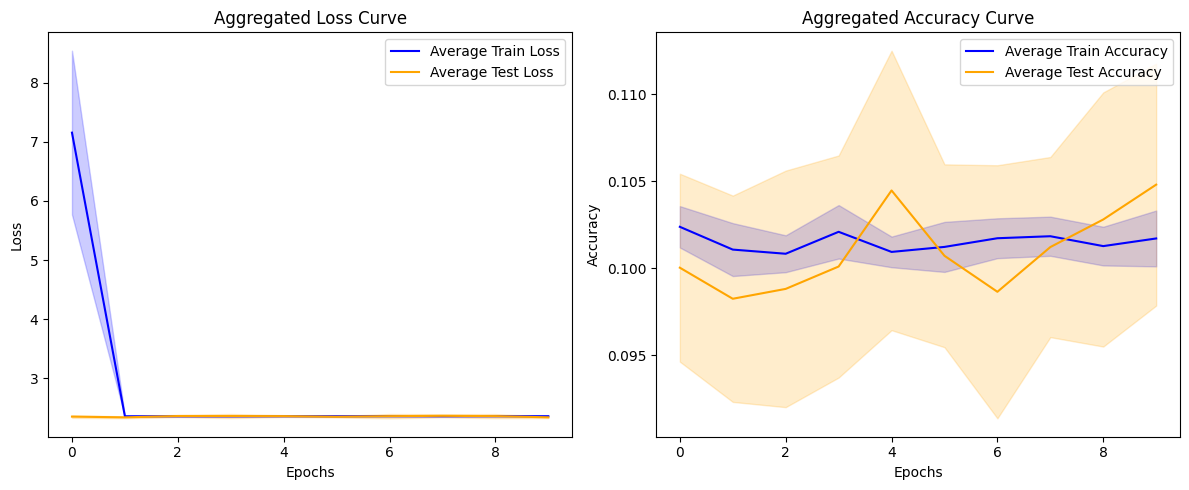

Accuracy: mean=10.480 std=0.694, n=10


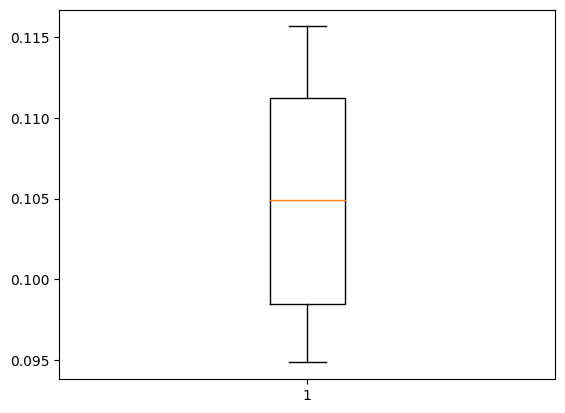

In [13]:
# baseline cnn model for mnist
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
import numpy as np

# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = mnist.load_data()
	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = Adam(learning_rate=0.5)   # OPTIMISATION ALGORITHM IS HERE
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

def evaluate_model(dataX, dataY, n_folds=10, epochs=10):
    scores, histories = list(), list()
    all_fold_metrics = {
        'accuracy': [],
        'stability': [],
        'rate_of_convergence': [],
        'mean_convergence_speed': [],
        'initial_accuracy': [],
        'mid_accuracy': [],
        'late_accuracy': []
    }

    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    
    # enumerate splits
    for fold_num, (train_ix, test_ix) in enumerate(kfold.split(dataX)):
        # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=epochs, batch_size=32, validation_data=(testX, testY), verbose=0)
        
        # calculate rate of convergence
        train_loss = history.history['loss']
        rate_of_convergence = [train_loss[i-1] - train_loss[i] for i in range(1, len(train_loss))]
        avg_rate_of_convergence = mean(rate_of_convergence)
        stability_metric = std(rate_of_convergence)
        mean_convergence_speed = avg_rate_of_convergence / len(train_loss)

        # calculate accuracy for each stage (first 5, middle, last 5)
        initial_accuracy = np.mean(history.history['accuracy'][:5])
        mid_accuracy = np.mean(history.history['accuracy'][epochs//2-2:epochs//2+3])  # middle 5 epochs
        late_accuracy = np.mean(history.history['accuracy'][-5:])
        
        # store fold metrics
        all_fold_metrics['accuracy'].append(history.history['accuracy'][-1])  # last epoch accuracy
        all_fold_metrics['stability'].append(stability_metric)
        all_fold_metrics['rate_of_convergence'].append(rate_of_convergence)
        all_fold_metrics['mean_convergence_speed'].append(mean_convergence_speed)
        all_fold_metrics['initial_accuracy'].append(initial_accuracy)
        all_fold_metrics['mid_accuracy'].append(mid_accuracy)
        all_fold_metrics['late_accuracy'].append(late_accuracy)

        # display fold metrics
        print(f"Fold {fold_num + 1}:")
        print(f"Accuracy at Last Epoch: {history.history['accuracy'][-1]:.3f}")
        print(f"Stability Metric (Standard Deviation of Convergence Rates): {stability_metric:.3f}")
        print(f"Rate of Convergence (Loss Reduction Per Epoch): {rate_of_convergence}")
        print(f"Average Rate of Convergence: {avg_rate_of_convergence:.3f}")
        print(f"Mean Convergence Speed: {mean_convergence_speed:.3f}")
        print(f"Initial Stage (Mean Accuracy for First 5 Epochs): {initial_accuracy:.3f}")
        print(f"Mid Stage (Mean Accuracy for Middle Epochs): {mid_accuracy:.3f}")
        print(f"Late Stage (Mean Accuracy for Last 5 Epochs): {late_accuracy:.3f}")
        print('-' * 50)

        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print(f"Test Accuracy: {acc * 100:.3f}%")
        print('=' * 50)

        # store scores and histories
        scores.append(acc)
        histories.append(history)

    # calculate and display mean metrics for the whole model
    mean_accuracy = np.mean(all_fold_metrics['accuracy'])
    mean_stability = np.mean(all_fold_metrics['stability'])
    mean_rate_of_convergence = np.mean(all_fold_metrics['rate_of_convergence'])
    mean_convergence_speed = np.mean(all_fold_metrics['mean_convergence_speed'])
    mean_initial_accuracy = np.mean(all_fold_metrics['initial_accuracy'])
    mean_mid_accuracy = np.mean(all_fold_metrics['mid_accuracy'])
    mean_late_accuracy = np.mean(all_fold_metrics['late_accuracy'])

    print("\nMean Performance Across All Folds:")
    print(f"Mean Accuracy: {mean_accuracy:.3f}")
    print(f"Mean Stability Metric: {mean_stability:.3f}")
    print(f"Mean Rate of Convergence: {mean_rate_of_convergence:.3f}")
    print(f"Mean Convergence Speed: {mean_convergence_speed:.3f}")
    print(f"Mean Initial Accuracy (First 5 Epochs): {mean_initial_accuracy:.3f}")
    print(f"Mean Mid Accuracy (Middle Epochs): {mean_mid_accuracy:.3f}")
    print(f"Mean Late Accuracy (Last 5 Epochs): {mean_late_accuracy:.3f}")

    return scores, histories




# Plot diagnostic learning curves
def summarize_diagnostics(histories, n_epochs=10):
    # Initialize lists to store data
    train_loss_all = np.zeros((len(histories), n_epochs))
    val_loss_all = np.zeros((len(histories), n_epochs))
    train_acc_all = np.zeros((len(histories), n_epochs))
    val_acc_all = np.zeros((len(histories), n_epochs))
    
    # Collect data from all folds
    for i, history in enumerate(histories):
        train_loss_all[i, :] = history.history['loss']
        val_loss_all[i, :] = history.history['val_loss']
        train_acc_all[i, :] = history.history['accuracy']
        val_acc_all[i, :] = history.history['val_accuracy']
    
    # Compute averages and standard deviations
    avg_train_loss = np.mean(train_loss_all, axis=0)
    avg_val_loss = np.mean(val_loss_all, axis=0)
    avg_train_acc = np.mean(train_acc_all, axis=0)
    avg_val_acc = np.mean(val_acc_all, axis=0)
    
    std_train_loss = np.std(train_loss_all, axis=0)
    std_val_loss = np.std(val_loss_all, axis=0)
    std_train_acc = np.std(train_acc_all, axis=0)
    std_val_acc = np.std(val_acc_all, axis=0)
    
    # Plot aggregated results
    plt.figure(figsize=(12, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.title('Aggregated Loss Curve')
    plt.plot(avg_train_loss, color='blue', label='Average Train Loss')
    plt.plot(avg_val_loss, color='orange', label='Average Test Loss')
    plt.fill_between(range(n_epochs), 
                     avg_train_loss - std_train_loss, 
                     avg_train_loss + std_train_loss, 
                     color='blue', alpha=0.2)
    plt.fill_between(range(n_epochs), 
                     avg_val_loss - std_val_loss, 
                     avg_val_loss + std_val_loss, 
                     color='orange', alpha=0.2)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.title('Aggregated Accuracy Curve')
    plt.plot(avg_train_acc, color='blue', label='Average Train Accuracy')
    plt.plot(avg_val_acc, color='orange', label='Average Test Accuracy')
    plt.fill_between(range(n_epochs), 
                     avg_train_acc - std_train_acc, 
                     avg_train_acc + std_train_acc, 
                     color='blue', alpha=0.2)
    plt.fill_between(range(n_epochs), 
                     avg_val_acc - std_val_acc, 
                     avg_val_acc + std_val_acc, 
                     color='orange', alpha=0.2)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    

# Visualize weights for a specific layer
def plot_weights(model, layer_index=0):
    # Extract weights from the specified layer
    weights, biases = model.layers[layer_index].get_weights()
    # Plot weights as a heatmap
    plt.figure(figsize=(10, 7))
    plt.title(f'Weights Heatmap for Layer {layer_index+1}')
    plt.imshow(weights[..., 0], cmap='viridis')  # Assuming 2D conv weights
    plt.colorbar()
    plt.show()

# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# box and whisker plots of results
	plt.boxplot(scores)
	plt.show()

# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# evaluate model
	scores, histories = evaluate_model(trainX, trainY)
	# learning curves
	summarize_diagnostics(histories)
	# summarize estimated performance
	summarize_performance(scores)

# entry point, run the test harness
run_test_harness()

Fold 1:
Accuracy at Last Epoch: 0.102
Stability Metric (Standard Deviation of Convergence Rates): 24.898
Rate of Convergence (Loss Reduction Per Epoch): [79.22601890563965, 0.0019347667694091797, -0.0019702911376953125, 0.00011205673217773438, 0.0016632080078125, -0.002390623092651367, 0.0024123191833496094, -0.0013861656188964844, 0.0015377998352050781]
Average Rate of Convergence: 8.803
Mean Convergence Speed: 0.880
Initial Stage (Mean Accuracy for First 5 Epochs): 0.100
Mid Stage (Mean Accuracy for Middle Epochs): 0.100
Late Stage (Mean Accuracy for Last 5 Epochs): 0.101
--------------------------------------------------
Test Accuracy: 10.400%
Fold 2:
Accuracy at Last Epoch: 0.102
Stability Metric (Standard Deviation of Convergence Rates): 52.340
Rate of Convergence (Loss Reduction Per Epoch): [166.54497718811035, -0.0004870891571044922, -0.0006945133209228516, 0.0002722740173339844, 0.00014591217041015625, 0.0011353492736816406, 0.0002570152282714844, -0.0009081363677978516, 0.0003

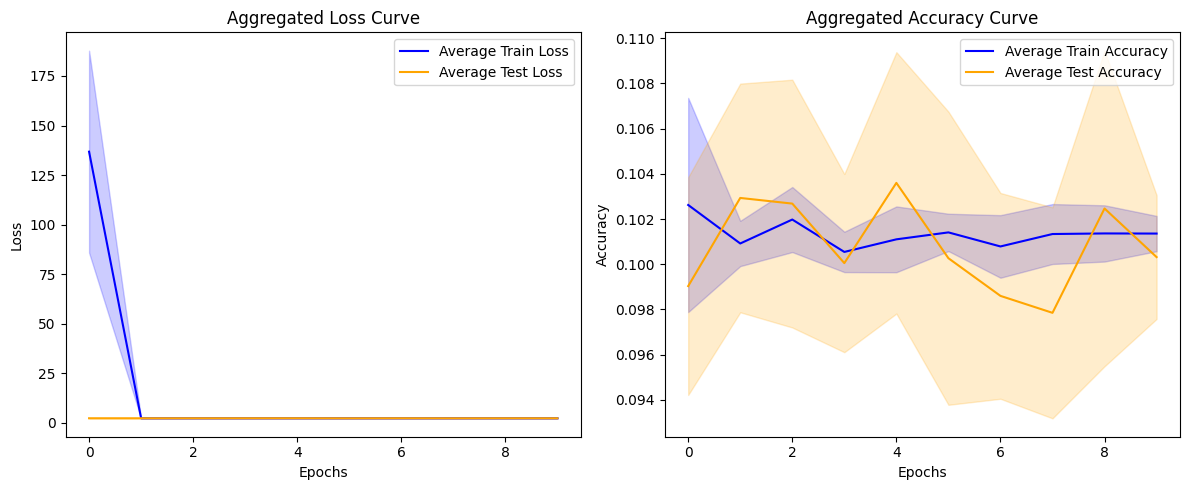

Accuracy: mean=10.032 std=0.274, n=10


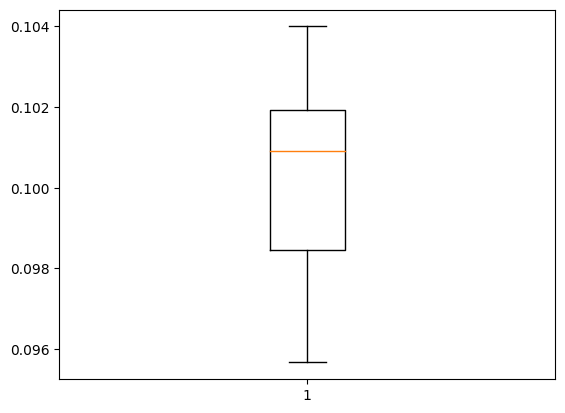

In [14]:
# baseline cnn model for mnist
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
import numpy as np

# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = mnist.load_data()
	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = RMSprop(learning_rate=0.5)   # OPTIMISATION ALGORITHM IS HERE
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

def evaluate_model(dataX, dataY, n_folds=10, epochs=10):
    scores, histories = list(), list()
    all_fold_metrics = {
        'accuracy': [],
        'stability': [],
        'rate_of_convergence': [],
        'mean_convergence_speed': [],
        'initial_accuracy': [],
        'mid_accuracy': [],
        'late_accuracy': []
    }

    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    
    # enumerate splits
    for fold_num, (train_ix, test_ix) in enumerate(kfold.split(dataX)):
        # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=epochs, batch_size=50, validation_data=(testX, testY), verbose=0)
        
        # calculate rate of convergence
        train_loss = history.history['loss']
        rate_of_convergence = [train_loss[i-1] - train_loss[i] for i in range(1, len(train_loss))]
        avg_rate_of_convergence = mean(rate_of_convergence)
        stability_metric = std(rate_of_convergence)
        mean_convergence_speed = avg_rate_of_convergence / len(train_loss)

        # calculate accuracy for each stage (first 5, middle, last 5)
        initial_accuracy = np.mean(history.history['accuracy'][:5])
        mid_accuracy = np.mean(history.history['accuracy'][epochs//2-2:epochs//2+3])  # middle 5 epochs
        late_accuracy = np.mean(history.history['accuracy'][-5:])
        
        # store fold metrics
        all_fold_metrics['accuracy'].append(history.history['accuracy'][-1])  # last epoch accuracy
        all_fold_metrics['stability'].append(stability_metric)
        all_fold_metrics['rate_of_convergence'].append(rate_of_convergence)
        all_fold_metrics['mean_convergence_speed'].append(mean_convergence_speed)
        all_fold_metrics['initial_accuracy'].append(initial_accuracy)
        all_fold_metrics['mid_accuracy'].append(mid_accuracy)
        all_fold_metrics['late_accuracy'].append(late_accuracy)

        # display fold metrics
        print(f"Fold {fold_num + 1}:")
        print(f"Accuracy at Last Epoch: {history.history['accuracy'][-1]:.3f}")
        print(f"Stability Metric (Standard Deviation of Convergence Rates): {stability_metric:.3f}")
        print(f"Rate of Convergence (Loss Reduction Per Epoch): {rate_of_convergence}")
        print(f"Average Rate of Convergence: {avg_rate_of_convergence:.3f}")
        print(f"Mean Convergence Speed: {mean_convergence_speed:.3f}")
        print(f"Initial Stage (Mean Accuracy for First 5 Epochs): {initial_accuracy:.3f}")
        print(f"Mid Stage (Mean Accuracy for Middle Epochs): {mid_accuracy:.3f}")
        print(f"Late Stage (Mean Accuracy for Last 5 Epochs): {late_accuracy:.3f}")
        print('-' * 50)

        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print(f"Test Accuracy: {acc * 100:.3f}%")
        print('=' * 50)

        # store scores and histories
        scores.append(acc)
        histories.append(history)

    # calculate and display mean metrics for the whole model
    mean_accuracy = np.mean(all_fold_metrics['accuracy'])
    mean_stability = np.mean(all_fold_metrics['stability'])
    mean_rate_of_convergence = np.mean(all_fold_metrics['rate_of_convergence'])
    mean_convergence_speed = np.mean(all_fold_metrics['mean_convergence_speed'])
    mean_initial_accuracy = np.mean(all_fold_metrics['initial_accuracy'])
    mean_mid_accuracy = np.mean(all_fold_metrics['mid_accuracy'])
    mean_late_accuracy = np.mean(all_fold_metrics['late_accuracy'])

    print("\nMean Performance Across All Folds:")
    print(f"Mean Accuracy: {mean_accuracy:.3f}")
    print(f"Mean Stability Metric: {mean_stability:.3f}")
    print(f"Mean Rate of Convergence: {mean_rate_of_convergence:.3f}")
    print(f"Mean Convergence Speed: {mean_convergence_speed:.3f}")
    print(f"Mean Initial Accuracy (First 5 Epochs): {mean_initial_accuracy:.3f}")
    print(f"Mean Mid Accuracy (Middle Epochs): {mean_mid_accuracy:.3f}")
    print(f"Mean Late Accuracy (Last 5 Epochs): {mean_late_accuracy:.3f}")

    return scores, histories




# Plot diagnostic learning curves
def summarize_diagnostics(histories, n_epochs=10):
    # Initialize lists to store data
    train_loss_all = np.zeros((len(histories), n_epochs))
    val_loss_all = np.zeros((len(histories), n_epochs))
    train_acc_all = np.zeros((len(histories), n_epochs))
    val_acc_all = np.zeros((len(histories), n_epochs))
    
    # Collect data from all folds
    for i, history in enumerate(histories):
        train_loss_all[i, :] = history.history['loss']
        val_loss_all[i, :] = history.history['val_loss']
        train_acc_all[i, :] = history.history['accuracy']
        val_acc_all[i, :] = history.history['val_accuracy']
    
    # Compute averages and standard deviations
    avg_train_loss = np.mean(train_loss_all, axis=0)
    avg_val_loss = np.mean(val_loss_all, axis=0)
    avg_train_acc = np.mean(train_acc_all, axis=0)
    avg_val_acc = np.mean(val_acc_all, axis=0)
    
    std_train_loss = np.std(train_loss_all, axis=0)
    std_val_loss = np.std(val_loss_all, axis=0)
    std_train_acc = np.std(train_acc_all, axis=0)
    std_val_acc = np.std(val_acc_all, axis=0)
    
    # Plot aggregated results
    plt.figure(figsize=(12, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.title('Aggregated Loss Curve')
    plt.plot(avg_train_loss, color='blue', label='Average Train Loss')
    plt.plot(avg_val_loss, color='orange', label='Average Test Loss')
    plt.fill_between(range(n_epochs), 
                     avg_train_loss - std_train_loss, 
                     avg_train_loss + std_train_loss, 
                     color='blue', alpha=0.2)
    plt.fill_between(range(n_epochs), 
                     avg_val_loss - std_val_loss, 
                     avg_val_loss + std_val_loss, 
                     color='orange', alpha=0.2)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.title('Aggregated Accuracy Curve')
    plt.plot(avg_train_acc, color='blue', label='Average Train Accuracy')
    plt.plot(avg_val_acc, color='orange', label='Average Test Accuracy')
    plt.fill_between(range(n_epochs), 
                     avg_train_acc - std_train_acc, 
                     avg_train_acc + std_train_acc, 
                     color='blue', alpha=0.2)
    plt.fill_between(range(n_epochs), 
                     avg_val_acc - std_val_acc, 
                     avg_val_acc + std_val_acc, 
                     color='orange', alpha=0.2)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    

# Visualize weights for a specific layer
def plot_weights(model, layer_index=0):
    # Extract weights from the specified layer
    weights, biases = model.layers[layer_index].get_weights()
    # Plot weights as a heatmap
    plt.figure(figsize=(10, 7))
    plt.title(f'Weights Heatmap for Layer {layer_index+1}')
    plt.imshow(weights[..., 0], cmap='viridis')  # Assuming 2D conv weights
    plt.colorbar()
    plt.show()

# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# box and whisker plots of results
	plt.boxplot(scores)
	plt.show()

# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# evaluate model
	scores, histories = evaluate_model(trainX, trainY)
	# learning curves
	summarize_diagnostics(histories)
	# summarize estimated performance
	summarize_performance(scores)

# entry point, run the test harness
run_test_harness()